In [3]:
import matplotlib.pyplot as plt # Bibliothek zum Zeichnen von Graphen
import numpy as np              # Lineare Algebra (Schnelle Matrix-Operationen)
import seaborn as sns           # Aufsatz auf matplotlib

# Egal atm
%matplotlib inline

In [4]:
# Diese Funktion beschreibt unsere "Ideal-linie"
def h_to_grade(h_in_fb:float) -> float:
    # f(x) = mx + n  (Geradengleichung: Kennt Ihr noch?! :-)
    # Frage: Wieso 5 / 24 ? Wieso + 1
    return 5./24. * h_in_fb + 1.

print("0  Stunden FB: ", h_to_grade(0.))
print("12 Stunden FB: ", h_to_grade(12.))
print("24 Stunden FB: ", h_to_grade(24.))

0  Stunden FB:  1.0
12 Stunden FB:  3.5
24 Stunden FB:  6.0


In [5]:
# Datensatz erstellen
datapoints = 200
# liste mit 200 Werten zwischen 0 24 erstellen
xs = np.random.rand(datapoints) * 24.
print("Erste 3 x-Elemente:", np.round(xs[0:3], 2))

# Funktionswerte berechnen "list comprehension"
ys = [h_to_grade(x) for x in xs]
print("Erste 3 y-Elemente:", np.round(ys[0:3], 2))

# Datenpunkte etwas "schütteln"
ys += np.random.normal(scale=.3, size=len(ys))

# oben und unten abschneiden
ys[ys > 6] = 6. # Das ist ein numpy Feature
ys[ys < 1] = 1. # Lies: alle ys an denen y < 1 auf 1 setzen

Erste 3 x-Elemente: [4.34 9.18 9.25]
Erste 3 y-Elemente: [1.91 2.91 2.93]


In [6]:
# Wollen wir uns das doch mal anschauen
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(x=xs, y=ys, marker="o", ax=ax, 
            fit_reg=False)
ax.set(xlabel="Hours on FB", ylabel="Grades", 
       title="Scatter plot")

[Text(0,0.5,'Grades'), Text(0.5,0,'Hours on FB'), Text(0.5,1,'Scatter plot')]

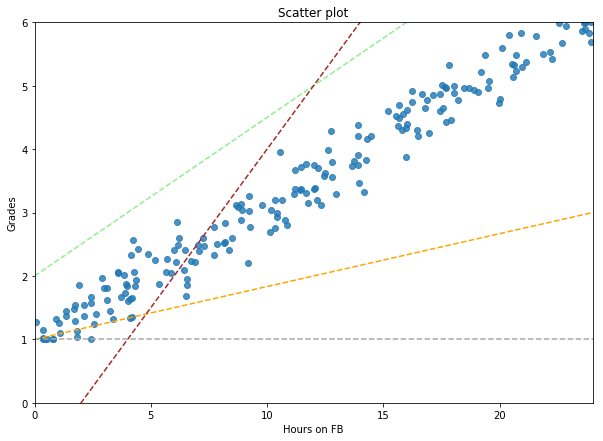

In [7]:
# Mögliche Linien
fig, ax = plt.subplots(figsize=(10, 7))
x_vals = np.linspace(0, 24, 2)
plt.sca(ax)
plt.plot(x_vals, [1/12 * x + 1 for x in x_vals], color="orange", linestyle="--")
plt.plot(x_vals, [1/4 * x + 2 for x in x_vals], color="lightgreen", linestyle="--")
plt.plot(x_vals, [1/2 * x - 1 for x in x_vals], color="brown", linestyle='--')
plt.plot(x_vals, [1 for x in x_vals], color="darkgray", linestyle='--')

sns.regplot(x=xs, y=ys, marker="o", ax=ax, 
            fit_reg=False)
_ = ax.set(xlabel="Hours on FB", ylabel="Grades", 
       title="Scatter plot", ylim=[0, 6], xlim=[0, 24])


In [8]:
import math # Sorry ;-)

def calc_factors(xs, ys):
    middle_x = sum(xs) / len(xs) # E[X]
    middle_y = sum(ys) / len(ys) # E[Y]
    sigma_x = 0.                 # (x - E[X])^2
    cov = 0.                     # (x - E[X]) * [y - E[Y]]
    
    for i in range(len(xs)):
        cov += (xs[i] - middle_x) * (ys[i] - middle_y)
        sigma_x += (xs[i] - middle_x)**2

    m = cov / sigma_x
    b = -m * middle_x + middle_y
    
    return m, b
    

In [9]:
m, b = calc_factors(xs, ys)

print("Geschätztes m: {:.5f} "\
      "(Original: {:.5f}),\n"\
      "Geschätztes b: {:.5f} "\
      "(Original: {:.5f})"
      .format(m, 5./24., b, 1.))

Geschätztes m: 0.21252 (Original: 0.20833),
Geschätztes b: 0.97153 (Original: 1.00000)


In [10]:
# Mögliche Linien
fig, ax = plt.subplots(figsize=(10, 7))
x_vals = np.linspace(0, 24, 10)

plt.plot(x_vals, [m*x + b for x in x_vals], color="orange", linestyle='--')

sns.regplot(x=xs, y=ys, marker="o", ax=ax, 
            fit_reg=False)
_ = ax.set(xlabel="Hours on FB", ylabel="Grades", 
       title="Scatter plot", ylim=[0, 6], xlim=[0, 24])

# Gradientenabstieg

## Zuerst definieren wir unser 𝜃
Da wir das nicht kennen, definieren wir es uns mit Zufallszahlen

In [11]:
𝜃 = np.random.normal(0, size=2)
print("m:", 𝜃[0], "b:", 𝜃[1])

m: -0.9074180403884912 b: -0.5596299392584042


Nun erweitern wir alle unsere Features um den <br />
konstanten Wert 1 (der b-Teil der normalen Gleichung)

In [14]:
# np.c_ steht für concat, Also das Anhängen von Werten.
# Wir fügen also jeder Zahl in xs eine eins hinzu und machen
# damit aus jedem xs -> [1, xs]
xs_with_bias = np.c_[np.ones(len(xs)), xs]
print(xs_with_bias[:3])

[[1.         4.34453503]
 [1.         9.17500668]
 [1.         9.25175618]]


## Nun definieren wir unsere Gradientenfunktion

In [273]:
def calc_gradients(𝜃, X, y):
    # Das @ ist ein Operator für das Dot-Produkt in numpy
    # Alternativ kann auch X.dot(𝜃) geschrieben werden
    return 2./float(len(X)) * X.T @ (X @ 𝜃 - y)

In [274]:
calc_gradients(𝜃=𝜃, X=xs_with_bias, y=ys)

array([  -7.99005592, -122.78875101])

## ... Und führen unsere Schritte aus

In [275]:
𝜂 = 0.001         # Kleine Learning Rate (Schrittlänge)
epochs = 10000    # Wieviele Schritte wollen wir laufen?
# Hier Achtung: Ein zu großer Wert wird divergieren!! (Zahlen explodieren)
# Ein zu kleiner dauert sehr lange bis Optimum (Wieder: Trade-Off)

for i in range(epochs):
    # Gradienten berechnen
    𝜃_prime = calc_gradients(𝜃=𝜃, X=xs_with_bias, y=ys)
    
    # Einen Schritt laufen
    𝜃 = 𝜃 - 𝜂 * 𝜃_prime

In [277]:
print("Geschätztes m: {:.5f} "\
      "(Original: {:.5f}),\n"\
      "Geschätztes b: {:.5f} "\
      "(Original: {:.5f})"
      .format(𝜃[1], 5./24., 𝜃[0], 1.))

Geschätztes m: 0.20616 (Original: 0.20833),
Geschätztes b: 1.01931 (Original: 1.00000)
